## This Notebook Uses ReSNet50 (Transfer Learning with PreTrained Weights and Retraining) Model to generate Output Predictions

#  <font color='red'>Table of Contents</font>


[9. ResNet50 Models](#section9)<br>


In [1]:
# Research Kernel Link - https://github.com/dimitreOliveira/APTOS2019BlindnessDetection/blob/master/Model%20backlog/ResNet50/4%20-%20ResNet50%20-%20Batch%20size%2022.ipynb

import pandas as pd
import numpy as np
import os
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Colab Libs...
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

8  CPU cores


#  <a id = 'section9'> <font color='red'>  9. ResNet50 Models  </font> </a>

### <font color='red'> 9.1 Setup Colab Environment </font>

In [2]:
def load_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
        
    train_dir = os.path.join('./','train_images/')
    test_dir = os.path.join('./','test_images/')
        
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
        
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
        
    train['diagnosis'] = train['diagnosis'].astype(str)
        
    return train,test

In [3]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)
df_test.head(6)

(3662, 4) (1928, 3) 



,id_code,file_path,file_name
0,0005cfc8afb6,./test_images/0005cfc8afb6.png,0005cfc8afb6.png
1,003f0afdcd15,./test_images/003f0afdcd15.png,003f0afdcd15.png
2,006efc72b638,./test_images/006efc72b638.png,006efc72b638.png
3,00836aaacf06,./test_images/00836aaacf06.png,00836aaacf06.png
4,009245722fa4,./test_images/009245722fa4.png,009245722fa4.png
5,009c019a7309,./test_images/009c019a7309.png,009c019a7309.png


In [4]:
from sklearn.model_selection import train_test_split
df_train_train,df_train_valid = train_test_split(df_train,test_size = 0.2)
print(df_train_train.shape,df_train_valid.shape)

(2929, 4) (733, 4)


In [6]:
def load_data():
    file = open('df_train_train', 'rb')
    df_train_train = pickle.load(file)
    file.close()

    file = open('df_train_valid', 'rb')
    df_train_valid = pickle.load(file)
    file.close()

        
    return df_train_train,df_train_valid

In [7]:
df_train_train,df_train_valid = load_data()
print(df_train_train.shape,df_train_valid.shape,'\n')
df_train_train.head(6)
df_train_valid.head(6)

(2929, 4) (733, 4) 



,id_code,diagnosis,file_path,file_name
2585,b376def52ccc,2,./train_images/b376def52ccc.png,b376def52ccc.png
3332,e740af6ac6ea,4,./train_images/e740af6ac6ea.png,e740af6ac6ea.png
3309,e59c5f345bb0,0,./train_images/e59c5f345bb0.png,e59c5f345bb0.png
3405,ec57cc20d776,0,./train_images/ec57cc20d776.png,ec57cc20d776.png
303,165cd2070ebd,4,./train_images/165cd2070ebd.png,165cd2070ebd.png
3591,fa748b57262b,2,./train_images/fa748b57262b.png,fa748b57262b.png


### <font color='red'> 9.2 Image Pre Processing </font>

In [8]:
IMG_SIZE = 512

In [9]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(file):
    input_filepath = os.path.join('./','train_images','{}.png'.format(file))
    output_filepath = os.path.join('./','valid_images_resized_preprocessed','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [10]:
'''This Function uses Multi processing for faster saving of images into folder'''

def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

In [15]:

multiprocess_image_processor(6, list(df_train_valid.id_code.values))

MESSAGE: Running 6 process


### <font color='red'> 9.3 Train Model </font>

In [11]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [12]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_valid,
                                                      directory = "./valid_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    
    return train_generator,valid_generator,test_generator

In [13]:
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_valid)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 447 validated image filenames.


c:\Python310\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 286 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [14]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense

# Assuming you have a function create_model defined
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax')(x)
    model = Model(input_tensor, final_output)

    return model

# Create the ResNet50 model with pre-trained weights
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)


In [15]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

293 73


In [16]:
model.compile(optimizer = optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=WARMUP_EPOCHS,
    verbose=1
)


Epoch 1/2
293/293 [==============================] - 1499s 5s/step - loss: 1.2764 - accuracy: 0.6536 - val_loss: 1.3653 - val_accuracy: 0.5017
Epoch 2/2
293/293 [==============================] - 1284s 4s/step - loss: 1.0698 - accuracy: 0.6596 - val_loss: 1.3988 - val_accuracy: 0.2534


In [17]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 326, 326, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 160, 160, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 160, 160, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

 rmalization)                                                                                     
                                                                                                  
 conv2_block1_add (Add)      (None, 80, 80, 256)          0         ['conv2_block1_0_bn[0][0]',   
                                                                     'conv2_block1_3_bn[0][0]']   
                                                                                                  
 conv2_block1_out (Activati  (None, 80, 80, 256)          0         ['conv2_block1_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv2_block2_1_conv (Conv2  (None, 80, 80, 64)           16448     ['conv2_block1_out[0][0]']    
 D)                                                                                               
          

In [18]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

C:\Users\giri2\AppData\Local\Temp\ipykernel_27812\1317685637.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_finetunning = model.fit_generator(generator=train_generator,


Epoch 1/40
293/293 [==============================] - 1362s 5s/step - loss: 0.3367 - accuracy: 0.6634 - val_loss: 0.4426 - val_accuracy: 0.2825 - lr: 0.0010
Epoch 2/40
293/293 [==============================] - 1428s 5s/step - loss: 0.3156 - accuracy: 0.6689 - val_loss: 0.3384 - val_accuracy: 0.6541 - lr: 0.0010
Epoch 3/40
293/293 [==============================] - 1369s 5s/step - loss: 0.3113 - accuracy: 0.6924 - val_loss: 0.3181 - val_accuracy: 0.6918 - lr: 0.0010
Epoch 4/40
293/293 [==============================] - 1338s 5s/step - loss: 0.2894 - accuracy: 0.7065 - val_loss: 0.2690 - val_accuracy: 0.6884 - lr: 0.0010
Epoch 5/40
293/293 [==============================] - 1326s 5s/step - loss: 0.2963 - accuracy: 0.6941 - val_loss: 0.3147 - val_accuracy: 0.6986 - lr: 0.0010
Epoch 6/40
293/293 [==============================] - 1296s 4s/step - loss: 0.2912 - accuracy: 0.6903 - val_loss: 0.2716 - val_accuracy: 0.7038 - lr: 0.0010
Epoch 7/40
293/293 [==============================] - 1265

KeyboardInterrupt: 

In [19]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

NameError: name 'history_finetunning' is not defined

<Figure size 800x500 with 0 Axes>

### <font color='red'> 9.4 Generate Train Predictions on complete Train Data </font>

In [51]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.
   1/2929 [..............................] - ETA: 6:32

C:\Windows\Temp\ipykernel_20924\1199064684.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)


2929/2929 [==============================] - 342s 117ms/step


In [32]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_preds))

Train Cohen Kappa score: 0.980
Train Accuracy score : 0.965


### <font color='red'> 9.5 Evaluate Model on Test Data </font>

In [33]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

733/733 [==============================] - 456s 622ms/step


In [ ]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

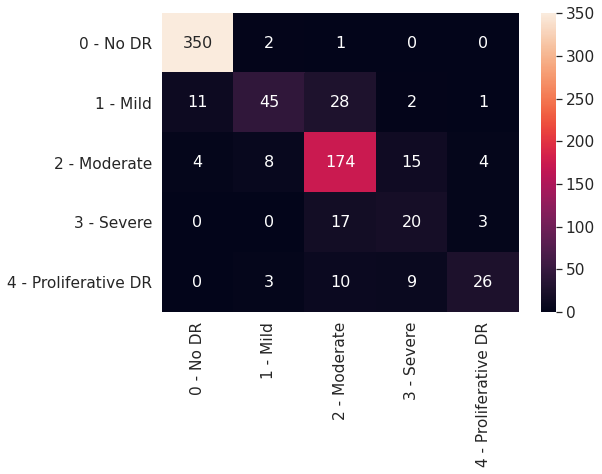

In [35]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_train_test['diagnosis'].astype(int)),test_labels,labels)

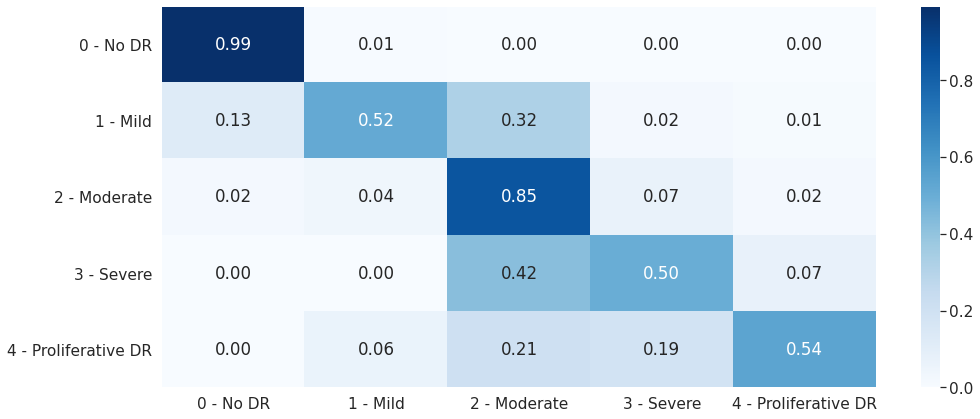

In [36]:
cnf_matrix = confusion_matrix(df_train_test['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [38]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))

Test Cohen Kappa score: 0.904
Test Accuracy score : 0.839


### <font color='red'> 9.6 ResNet50 Models Summary </font>

In [39]:
x = PrettyTable()
x.field_names = ["S.No.","ResNet50 Model","Image Processing","Data Augmentation","Hyperparameters(BS,Opt,lr,ep)","Train QWK","Test QWK"]

x.add_row([1,"R-P-D-p(0.5)-D-p(0.5)-S(5)","--","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.912","0.905"])
x.add_row([2,"R-P-D-p(0.5)-D-p(0.5)-S(5)","Circle Crop, Gaussian Blur","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.98","0.904"])

print(x)

+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
| S.No. |       ResNet50 Model       |      Image Processing      |  Data Augmentation   | Hyperparameters(BS,Opt,lr,ep) | Train QWK | Test QWK |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
|   1   | R-P-D-p(0.5)-D-p(0.5)-S(5) |             --             | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |   0.912   |  0.905   |
|   2   | R-P-D-p(0.5)-D-p(0.5)-S(5) | Circle Crop, Gaussian Blur | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |    0.98   |  0.904   |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
